<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-A01793006/blob/main/A01793006_TecMty_kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATOS GENERALES**

Alumna: Diana Valeria Garcia Briones

Matricula: A01793006

Semana 07 - K Means



---


Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [ ]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [ ]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [ ]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

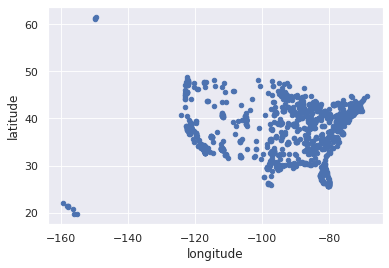

In [ ]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [ ]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [ ]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [ ]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [ ]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

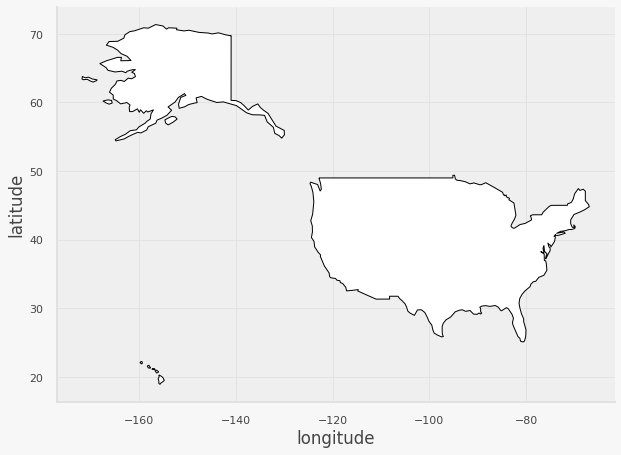

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

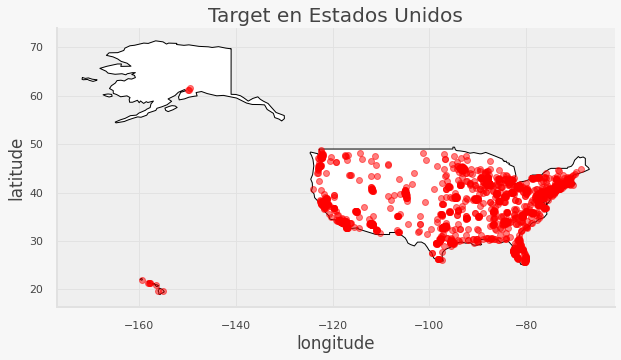

In [ ]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

#Desarrollo del Ejercicio

In [ ]:
#Importacion de las librerias necesarias para Kmeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

In [ ]:
#Names = pd.DataFrame(df.name.unique(),
X1= df.drop_duplicates(subset=['name'])
X1

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)
...,...,...,...,...,...,...,...
1834,Waukesha,43.034293,-88.176840,"2401 Kossow Rd, Waukesha, WI 53186-2904",262-784-8646,https://www.target.com/sl/waukesha/82,POINT (-88.17684 43.03429)
1835,Waukesha South,42.989604,-88.259806,"1250 W Sunset Dr, Waukesha, WI 53189-8423",262-832-1272,https://www.target.com/sl/waukesha/2546,POINT (-88.25981 42.98960)
1836,Casper,42.846799,-106.264166,"401 SE Wyoming Blvd, Casper, WY 82609-4219",307-265-8214,https://www.target.com/sl/casper/164,POINT (-106.26417 42.84680)
1837,Cheyenne,41.162019,-104.800048,"1708 Dell Range Blvd, Cheyenne, WY 82009-4945",307-637-8888,https://www.target.com/sl/cheyenne/224,POINT (-104.80005 41.16202)


In [ ]:
#Almacenamos en una tabla unicamente los valores que necesitamos
X1=X1.loc[:,['name','latitude','longitude']]
X1.head(10)

,name,latitude,longitude
0,Alabaster,33.224225,-86.804174
1,Bessemer,33.334550,-86.989778
2,Daphne,30.602875,-87.895932
3,Decatur,34.560148,-86.971559
4,Dothan,31.266061,-85.446422
5,Florence,34.842085,-87.633908
6,Fultondale,33.606040,-86.805557
7,Gulf Shores,30.303980,-87.679995
8,Homewood,33.467142,-86.775100
9,Madison,34.748820,-86.756250


**Elbow Curve**

Utilizamos este metodo para validar el numero de clusters optimo para nuestro modelo de K-means, funciona calculando La Suma del Error Cuadrado de cada K y es seleccionado el que tenga un punto mayor o cercano a 1.

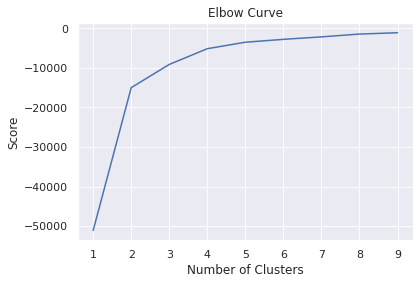

In [ ]:
#Curva utilizando SSE

K_clusters = range(1,10) #Probara con 10 Clusters
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = X[['latitude']]
X_axis = X[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualizacion
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Podemos optar por seleccionar 3 o 4 clusters (almacenes) puesto que son donde se tiene incrementos mas significativo, la cantidad de clusters posteriores no aportarian signivicativamente al modelo por lo que solo representa una inversion de recursos inecesarios.

In [ ]:
#Modelo de K-means
X = df[["longitude","latitude"]]

kmeans = KMeans(n_clusters = 4, init ='k-means++') # Calculo de las K-mean y numero de clusters
kmeans.fit(X[X.columns[0:2]])

X['cluster_label'] = kmeans.fit_predict(X[X.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordenadas de los centros
labels = kmeans.predict(X[X.columns[0:2]]) # Cluster por registro

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
#Validamos la cantidad de Clusters creados
X.cluster_label.unique()

array([1, 2, 0, 3], dtype=int32)

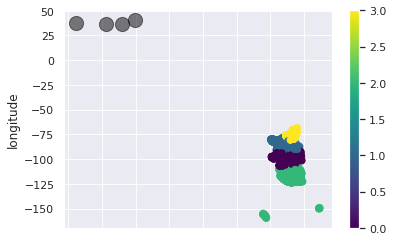

In [ ]:
#Visualizacion de los grupos resultantes
X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
#Almacenamiento de los centros
ck = pd.DataFrame(centers)
ck

,0,1
0,-96.972788,36.995055
1,-84.811949,36.557344
2,-119.146456,37.577577
3,-75.275533,40.332247


In [ ]:
#Almacenamos las Longitud y Latitud de los centros como Coordenada en una variable
ck["Coordinates"] = list(zip(ck[0], ck[1]))
ck["Coordinates"] = ck["Coordinates"].apply(Point)

gdf_k = gpd.GeoDataFrame(ck, geometry="Coordinates")
gdf_k.head()

,0,1,Coordinates
0,-96.972788,36.995055,POINT (-96.97279 36.99506)
1,-84.811949,36.557344,POINT (-84.81195 36.55734)
2,-119.146456,37.577577,POINT (-119.14646 37.57758)
3,-75.275533,40.332247,POINT (-75.27553 40.33225)


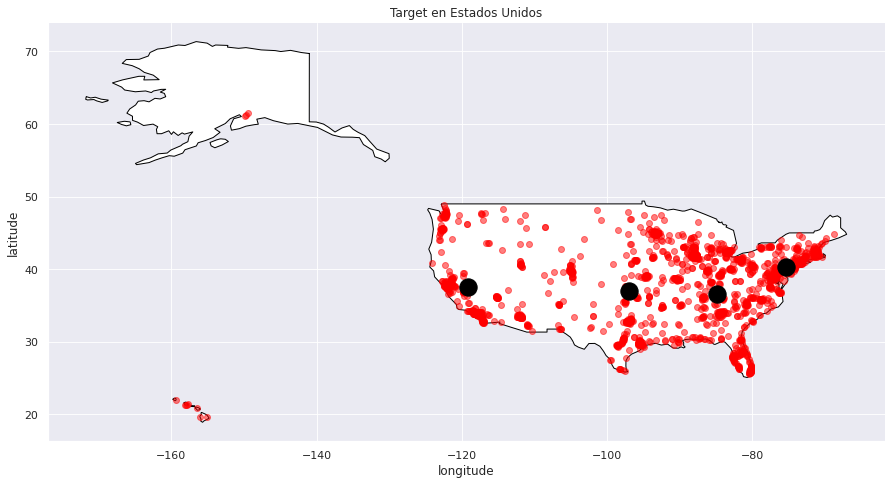

In [ ]:
#Creamos la Visualizacion del mapa
fig, gax = plt.subplots(figsize=(15,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white') #Aqui traemos el mapa de los unites

gdf.plot(ax=gax, color='red', alpha = 0.5) #Aqui grafica los datos originales
gdf_k.plot(ax=gax, color='black', alpha = 1, markersize = 300) #Aqui grafica los datos de nuestro dataset de arriba

#De aqui para abajo es puro ploting busines
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [ ]:
#Conteo de valores agrupados por Cluster
latlong['kmeans'] = (kmeans.labels_)
latlong.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1    615
3    454
0    401
2    369
Name: kmeans, dtype: int64

In [ ]:
#Almacenamos las coordenadas de los Clusters (Almacenes en variables)
Almacen1 = str(gdf_k[1][0]) + ", " + str(gdf_k[0][0])
Almacen2 = str(gdf_k[1][1]) + ", " + str(gdf_k[0][1])
Almacen3 = str(gdf_k[1][2]) + ", " + str(gdf_k[0][2])
Almacen4 = str(gdf_k[1][3]) + ", " + str(gdf_k[0][3])


En la siguiente celda encontramos el codigo para: Obtener la locacion de los Almacenes.

Para esto, utilizamos las coordenadas del cluster(almacen) y con dichas coordenadas utilizamos la libreria Geocoders para encontrar la ubicacion exacta segun la longitud y latitud de donde se recomienda poner el almacen:



In [ ]:
#Locacion de los almacenes con las coordenadas
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic

Geo = Nominatim(user_agent="my-application") #Inicializamos la libreria
Almacenes = [Almacen1, Almacen2, Almacen3, Almacen4] #Metemos las coordenadas obtenidas

for i in Almacenes:
  location = Geo.reverse(i) 
  print('almacen en ---', location.address)


almacen en --- 332nd Road, Cowley County, Kansas, United States
almacen en --- Spaughs Ridge Road, Pickett County, Tennessee, United States
almacen en --- Mammoth Trail, Madera County, California, United States
almacen en --- Diamond Street, Hilltown Township, Bucks County, Pennsylvania, 18962, United States


En la siguiente celda encontramos el codigo para: Obtener la distancia entre los Almacenes.

Para esta actividad utilizamos la funcion de GeoDesic que nos ayuda a calcular la distancia entre dos puntos de coordenadas, por lo que podemos comparar la distancia entre la ubicacion recomendada de cada almacen.


In [ ]:
#Distancia entre almacenes en base a su ubicacion
dis1 = str(geodesic(Almacen1, Almacen2).miles)
print("\nDistancia entre el 1er y 2do almacen : ", dis1, " millas \n") 
dis2 = str(geodesic(Almacen2, Almacen3).miles)
print("Distancia entre el 2do y 3er almacen : ", dis2, " millas \n")
dis3 = str(geodesic(Almacen3, Almacen4).miles)
print("Distancia entre el 3er y 4to almacen : ", dis3, " millas \n")


Distancia entre el 1er y 2do almacen :  674.7894078349053  millas 

Distancia entre el 2do y 3er almacen :  1888.0432204712672  millas 

Distancia entre el 3er y 4to almacen :  2346.3893796007856  millas 



**Conclusiones**

De acuerdo con los resultados obtenidos durante el ejercicio, podemos concluir gracias al metodo Elbow que la cantidad de almacenes que podrian reprsentar una inversion favorable eran 4, pues a partir de dicho numero la cantidad de tiendas que podian surtir, no aumentaba de forma significativa lo que generaria un gasto no justificable.

Teniendo como resultado la ubicacion (utilizamos la libreria Geonomatic) de los almacenes asi como la cantidad de tiendas que podrian surtir (Conteo de tiendas con base al clustering), obtenemos que:

1. El almacen con ubicacion en Tenesse, tiene la capacidad de surtir 615 tiendas dentro de su rango.
2. El almacen con ubicacion en Pennsylvania, tiene la capacidad de surtir 454 tiendas dentro de su rango.
3. El almacen con ubicacion en Kansas, tiene la capacidad de surtir 401 tiendas dentro de su rango.
4. El almacen con ubicacion en California, tiene la capacidad de surtir 369 tiendas dentro de su rango.

De manera adicional, destacar que las librerias que se añadiaeron a las obtenidas en los recursos fueron:

1. Geopandas para poder realizar operaciones con las coordenadas, latitud y longitud.
2. Geocodes para encontrar la ubicacion de un punto, utilizando las coordenadas.
3. Distance para poder medir las distancias entre coordenadas.

Para el tipo de analisis donde se tienen datos geoespaciales consideramos indispensable realizar graficas utilizando mapas desde el analisis, para poder tener un mejor entendimiento de los mismos. Pues coordenadas alejadas o latitudes negativas, al ser analizadas de otras formas podrian ser considerados como datos atipicos o ruido.

Un ejemplo de esto es el caso de Alaska, al utilizar una grafica convencional para analizar el resultado de los K-Means este era considerado como un outlier, sin embargo, este resultado era ocasionado debido a la ubicacion del estado y no a sus datos.